In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [156]:
import lime
from lime.lime_text import LimeTextExplainer

# Data Preprocessing

In [2]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [3]:
true['label'] = 'True'
fake['label'] = 'Fake'

In [4]:
fake.shape

(23481, 5)

In [5]:
true.shape

(21417, 5)

In [6]:
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
data.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date label  
0  December 31, 2017  Fake  
1  December 31, 2017  Fake  
2  December 30, 2017  Fake  
3  December 29, 2017  Fake  
4  December 25, 2017  Fake

In [8]:
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)
data.drop(["date"],axis=1,inplace=True)
data.drop(["title"],axis=1,inplace=True)
data.head()

text    subject label
0  PARIS (Reuters) - Russian businessman Suleiman...  worldnews  True
1  Listening to Zeke Emanuel, awkward brother of ...   politics  Fake
2  Actor Kevin Sorbo and his wife, actress Sam So...  left-news  Fake
3  Ted Cruz s presidential campaign is gaining a ...       News  Fake
4  Michelle Obama is hands-down, the most divisiv...   politics  Fake

In [9]:
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

text    subject label
0  paris (reuters) - russian businessman suleiman...  worldnews  True
1  listening to zeke emanuel, awkward brother of ...   politics  Fake
2  actor kevin sorbo and his wife, actress sam so...  left-news  Fake
3  ted cruz s presidential campaign is gaining a ...       News  Fake
4  michelle obama is hands-down, the most divisiv...   politics  Fake

In [10]:
import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

In [11]:
data['text'] = data['text'].apply(punctuation_removal)

In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moyan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


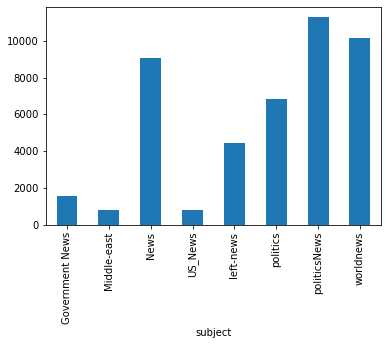

In [13]:
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

label
Fake    23481
True    21417
Name: text, dtype: int64


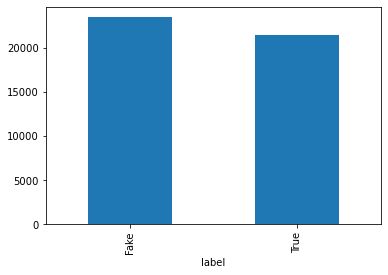

In [14]:
print(data.groupby(['label'])['text'].count())
data.groupby(['label'])['text'].count().plot(kind="bar")
plt.show()

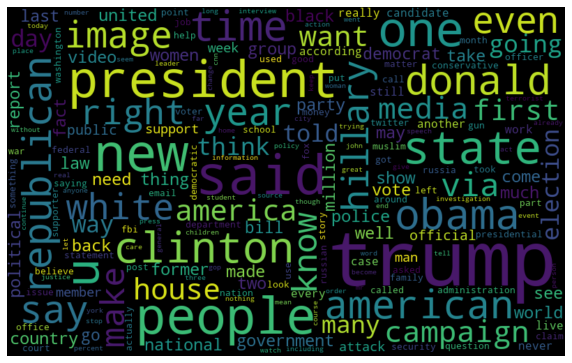

In [15]:
!pip install wordcloud
from wordcloud import WordCloud

fake_data = data[data["label"] == "Fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,max_font_size = 110,collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

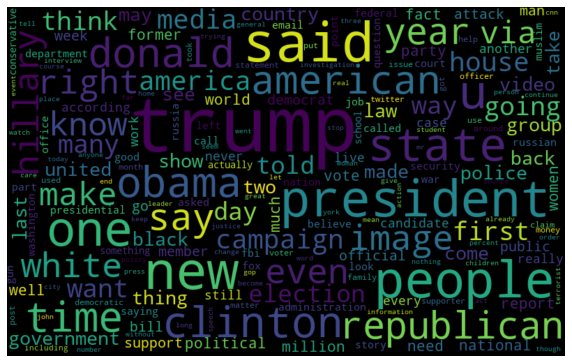

In [16]:
real_data = data[data["label"] == "True"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,max_font_size = 110,collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [17]:
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

# to find most frequent words of some category
def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

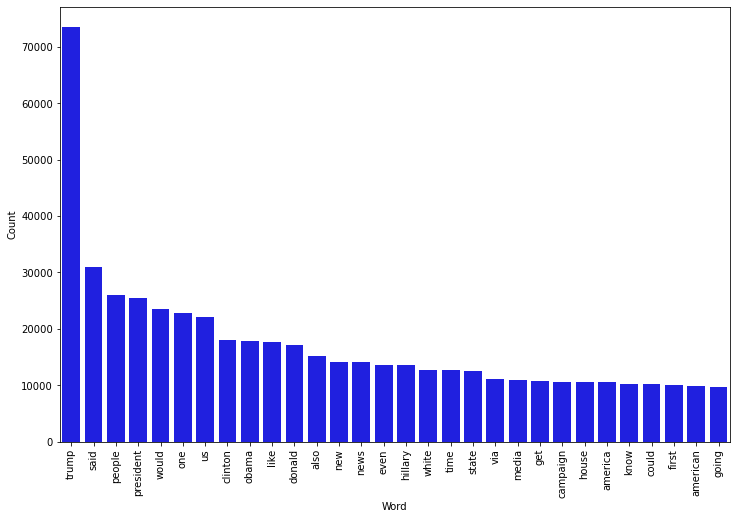

In [18]:
counter(data[data["label"] == "Fake"], "text", 30)

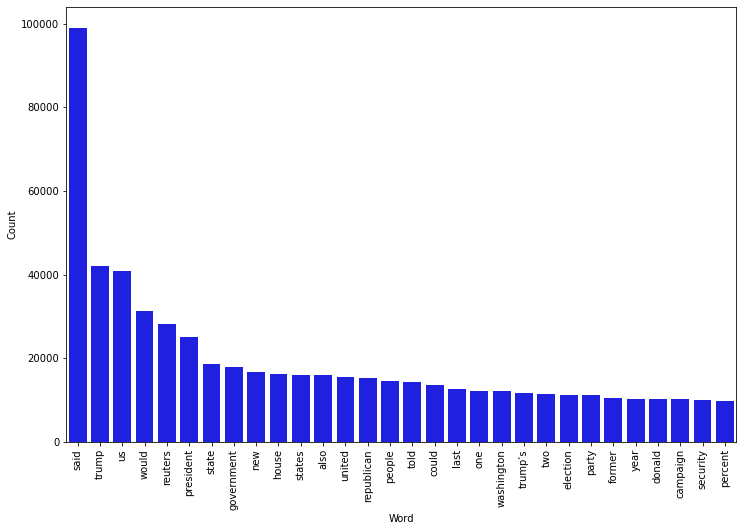

In [19]:
counter(data[data["label"] == "True"], "text", 30)

In [20]:
from sklearn import metrics
import itertools

# to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Splitting the dataset into training and testing sets

In [21]:
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.label, test_size=0.2, random_state=1)

# Models training and testing

### Model 1: Decision Tree 

In [157]:
from sklearn.tree import DecisionTreeClassifier
pipe_dt = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',max_depth = 20, splitter='best', random_state=1))])

# Fitting the model
model_dt = pipe_dt.fit(X_train, y_train)

# Accuracy
prediction = model_dt.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.54%


Confusion matrix, without normalization


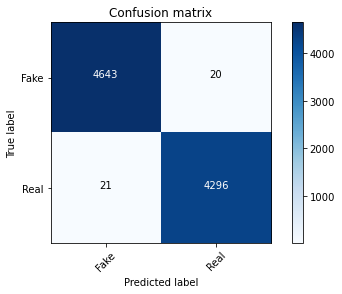

In [158]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

As seen above we can get the following insights:
1. There are 4679 cases where model predicted fake and news was fake
2. There are 4267 cases where model predicted true and news was true
3. There are 20 cases where the model predicted false while the news was true
4. There are 14 cases where the model predicted true while the news was false
5. The total accuracy attained is <b>99.62%</b><br><br>
<b>(The values might change by a small amount when run at different times)</b>

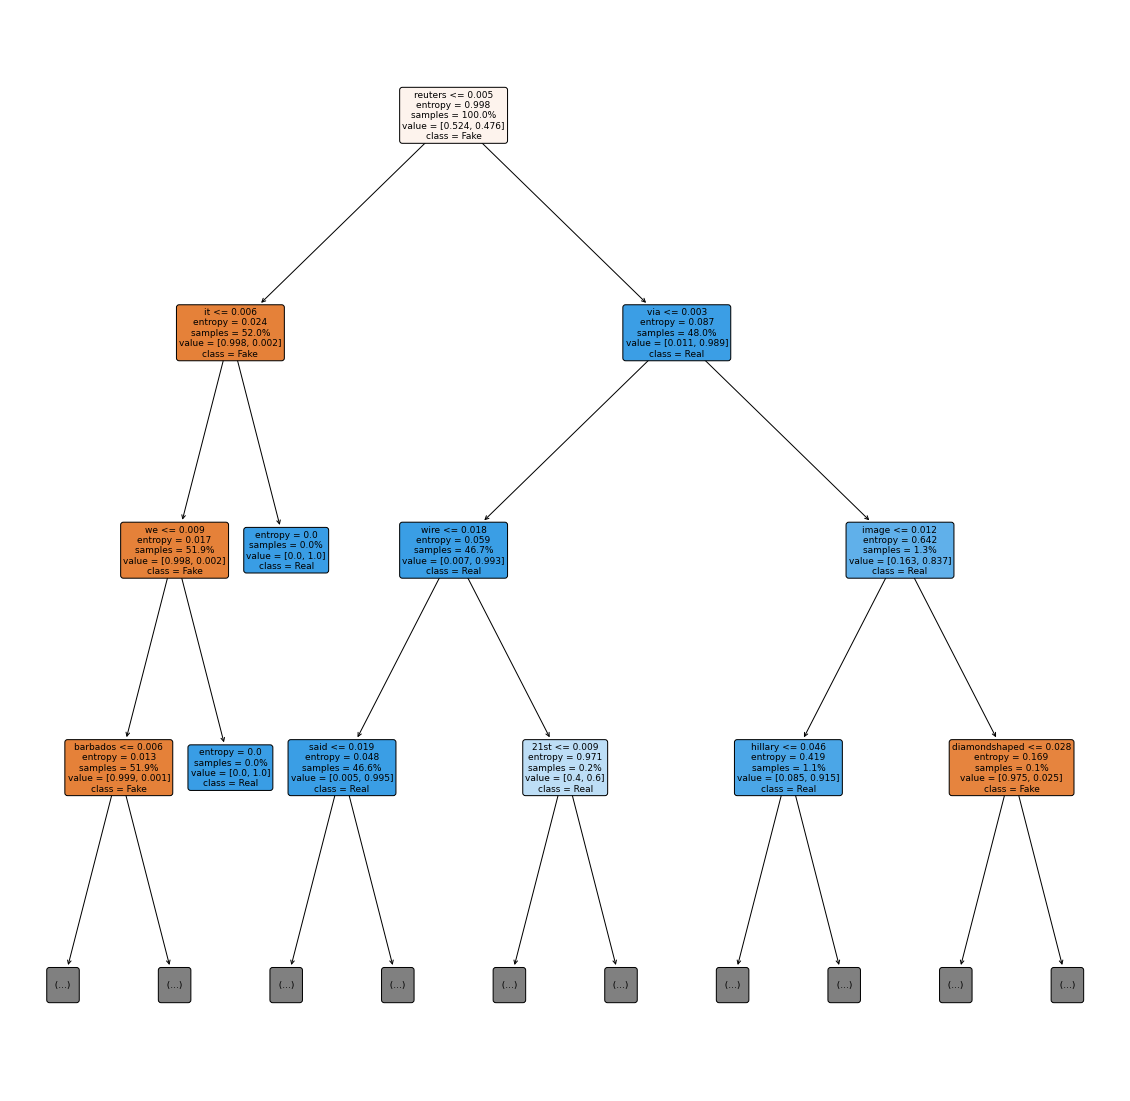

In [159]:
from sklearn.tree import plot_tree
importances = model_dt['model'].feature_importances_
indices = np.argsort(importances)
features = pipe_dt['vect'].get_feature_names()
fig = plt.figure(figsize=(20, 20))
vis = plot_tree(model_dt['model'], feature_names = features, class_names = ['Fake', 'Real'], max_depth=3, fontsize=9, proportion=True, filled=True, rounded=True)

In [43]:
# Saving the model for future uses
import pickle
filename_dt = 'Saved_Models/FakeNews_DecisionTree_resaved.sav'
pickle.dump(model_dt, open(filename_dt, 'wb'))

### Model 2: Random Forest Classifier

In [60]:
from sklearn.ensemble import RandomForestClassifier

pipe_rfc = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model_rfc = pipe_rfc.fit(X_train, y_train)
prediction = model_rfc.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.96%


Confusion matrix, without normalization


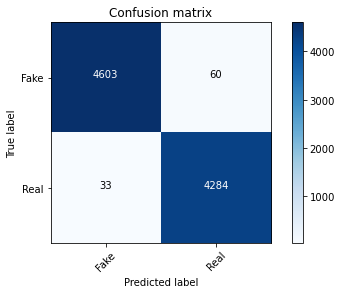

In [61]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

As seen above we can get the following insights:
1. There are 4635 cases where model predicted fake and news was fake
2. There are 4262 cases where model predicted true and news was true
3. There are 25 cases where the model predicted false while the news was true
4. There are 58 cases where the model predicted true while the news was false
5. The total accuracy attained is <b>99.08%</b><br><br>
<b>(The values might change by a small amount when run at different times)</b>

In [135]:
explainer = LimeTextExplainer(class_names = ['Fake','True'])

idx = 0
exp = explainer.explain_instance(X_test.iloc[idx], model_rfc.predict_proba,labels = [0,1])
print('Document id: %d' % idx)
print('Predicted class =', model_rfc.predict([X_test.iloc[idx]])[0])
print('True class: %s' % y_test.iloc[idx])

Document id: 0
Predicted class = True
True class: True


In [136]:
X_test.iloc[idx]

'november 28 story corrected clarify headline lead third paragraph broadcasters promote concerts dropped plans air concerts berlin reuters german public broadcasters dropped plans promote concerts next year british expink floyd frontman roger waters citing call accusations antisemitism waters part one world critically acclaimed commercially successful rock bands 196585 going solo member palestinianled boycott divestment sanctions movement bds targets israel occupation territories palestinians seek statehood five state television radio affiliates national ard network said promote concerts 74yearold waters berlin cologne scheduled next summer reaction antisemitism accusations berlin brandenburg public radio rbb said rbb part ard network said wanted send message artists heeding bds refuse perform israel waters joined movement 2011 taking clear position important signal rbb jewish communities berlin brandenburg rbb director patricia schlesinger said statement quick decisive reaction broadc

In [137]:
class_names = ['Fake','True']
print ('Explanation for class %s' % class_names[1])
print ('\n'.join(map(str, exp.as_list(label=1))))

Explanation for class True
('said', 0.1274696498125944)
('reuters', 0.09164786005659745)
('daily', -0.03919316638313417)
('economic', 0.0359020047216815)
('berlin', 0.035340498629209315)
('minister', 0.03405957392227873)
('statement', 0.03220387069424271)
('ridiculous', -0.029028013513797878)
('clearly', -0.02609163372196727)
('year', -0.02204199613400509)


In [138]:
print ('Explanation for class %s' % class_names[0])
print ('\n'.join(map(str, exp.as_list(label=0))))

Explanation for class Fake
('said', -0.1274696498125944)
('reuters', -0.0916478600565974)
('daily', 0.03919316638313417)
('economic', -0.03590200472168152)
('berlin', -0.035340498629209335)
('minister', -0.03405957392227868)
('statement', -0.03220387069424272)
('ridiculous', 0.029028013513797888)
('clearly', 0.026091633721967256)
('year', 0.02204199613400508)


In [139]:
exp.show_in_notebook(text=X_test.iloc[idx], labels=(1,))

In [141]:
import pickle
filename_rfc = 'Saved_Models/FakeNews_RandomForestClassifier_resaved.sav'
pickle.dump(model_rfc, open(filename_rfc, 'wb'))

### Multinomial Naive Bayes

In [147]:
from sklearn.naive_bayes import MultinomialNB
pipe_nb = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', MultinomialNB())])

model_nb = pipe_nb.fit(X_train, y_train)
prediction = model_nb.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 95.56%


Confusion matrix, without normalization


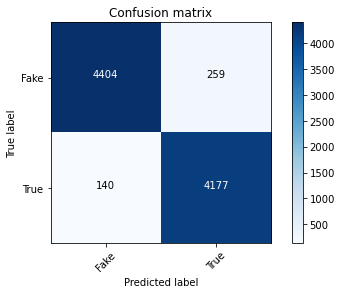

In [149]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'True'])

As seen above we can get the following insights:
1. There are 4413 cases where model predicted fake and news was fake
2. There are 4145 cases where model predicted true and news was true
3. There are 142 cases where the model predicted false while the news was true
4. There are 280 cases where the model predicted true while the news was false
5. The total accuracy attained is <b>95.30%</b><br><br>
<b>(The values might change by a small amount when run at different times)</b>

In [150]:
explainer = LimeTextExplainer(class_names = ['Fake','True'])

idx = 0
exp = explainer.explain_instance(X_test.iloc[idx], model_nb.predict_proba,labels = [0,1])
print('Document id: %d' % idx)
print('Predicted class =', model_nb.predict([X_test.iloc[idx]])[0])
print('True class: %s' % y_test.iloc[idx])

Document id: 0
Predicted class = True
True class: True


In [151]:
class_names = ['Fake','True']
print ('Explanation for class %s' % class_names[1])
print ('\n'.join(map(str, exp.as_list(label=1))))

Explanation for class True
('berlin', 0.08994293641849717)
('bds', -0.06447547642401125)
('waters', -0.060921207145008836)
('broadcasters', 0.05676158196477142)
('germany', 0.04426569157295037)
('israel', 0.04384501344000433)
('ard', 0.040366648412575284)
('german', 0.03506978742508349)
('said', 0.02555456988177306)
('concerts', -0.022758610856561598)


In [152]:
print ('Explanation for class %s' % class_names[0])
print ('\n'.join(map(str, exp.as_list(label=0))))

Explanation for class Fake
('berlin', -0.08994293641849702)
('bds', 0.06447547642401125)
('waters', 0.0609212071450089)
('broadcasters', -0.05676158196477124)
('germany', -0.04426569157295015)
('israel', -0.04384501344000453)
('ard', -0.04036664841257529)
('german', -0.03506978742508357)
('said', -0.02555456988177324)
('concerts', 0.02275861085656159)


In [153]:
exp.show_in_notebook(text=X_test.iloc[idx], labels=(1,))

In [155]:
import pickle
filename_nb = 'Saved_Models/FakeNews_MultinomialNaiveBayes_resaved.sav'
pickle.dump(model_nb, open(filename_nb, 'wb'))

In [ ]:
'''
# load the model from disk
news_article = ''
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(news_article)
'''